# Suspicious suppliers

In [29]:
import pandas as pd
import numpy as np

import re
from unidecode import unidecode

import seaborn as sns

In [32]:
stop_words = [
    r"S\.?A\.? *DE\.? *C\.?V\.?",
    r"S\.? *DE\.? *R\.?L\.? *DE *C\.?V\.?",
    r"S\.?A\.?P\.?I\.? *DE\.? *C\.?V\.?",
    r"S\.?A\.?B\.? *DE\.? *C\.?V\.?",
    r"S\.? *DE\.? *R\.?L\.?",
    r"\bL\.? *T\.? *D\.?\b",
    r"\bS\.? *A\.?\b",
    r"\bR\.? *L\.?\b",
    r"\bC\.? *V\.?\b",
    r"\bS\.? *C\.?\b",
    r"\bS\.? *C\.? *L\.?",
    r"\bS\.?A\.?P\.?I\.?\b",
    r"S\.A\.S\.?"]

In [33]:
def norm(x):
    for word in stop_words:
        x = re.sub(word, "", x)
    x = x.replace(".", "")
    x = x.replace(",", "")
    return unidecode(x.strip().lower())

In [34]:
cnts = pd.read_csv("../data/pre-process/contratos_4.csv", parse_dates=['start_date'])

In [35]:
cnts['year'] = cnts.start_date.dt.year

In [36]:
cnts = cnts.drop('CRI', axis=1)

In [37]:
cnts['normed'] = cnts['supplier'].apply(norm)

In [38]:
parts = pd.read_json("../data/tables/s3-particulares-sfp.json")
parts['year'] = pd.to_datetime(parts.fechaCaptura).dt.year.astype(int)
parts = parts[['nombreRazonSocial', 'year']]

parts['normed'] = parts['nombreRazonSocial'].apply(norm)

# Sanctioned suppliers

In [39]:
s = set(cnts['normed'].unique()) & set(parts['normed'].unique())

In [40]:
cnts['sanctioned'] = 0

In [41]:
cnts.loc[cnts.normed.isin(s), 'sanctioned'] = 1

# Fake companies

In [42]:
fantasmas = pd.read_csv("../data/tables/fantasmas.csv", delimiter="\n", names=['supplier'])

fantasmas['normed'] = fantasmas['supplier'].apply(norm)

In [43]:
s2 = set(cnts['normed'].unique()) & set(fantasmas['normed'].unique())

In [44]:
cnts.loc[cnts.normed.isin(s2), 'sanctioned'] = 1

# Disapearing suppliers in 2019

In [45]:
supplier_18 = cnts[cnts['year']==2018].groupby('usupplier').size().rename("N").reset_index()

In [46]:
s18 = set(supplier_18[supplier_18.N >= supplier_18.N.mean()]['usupplier'].unique())

In [47]:
s19 = set(cnts[cnts.year==2019]['usupplier'].unique())

In [48]:
cnts['unstable'] = 0
cnts.loc[cnts.usupplier.isin(s18 - s19), 'unstable'] = 1

In [62]:
n_sanctioned = (cnts.sanctioned==1).sum()

In [63]:
n_unstable = (cnts.unstable==1).sum()

In [66]:
cnts[cnts.sanctioned==1].interaction.mean()

4.764110948276914

In [68]:
cnts[cnts.unstable==1].interaction.mean()

11.631388779506333

In [72]:
cnts_ran = cnts[(cnts.unstable==0) & (cnts.sanctioned==0)]

In [67]:
cnts.interaction.mean()

42.00543887797826

In [69]:
cnts[cnts.unstable==1].s_interaction.mean()

13.280561616527372

In [70]:
cnts[cnts.sanctioned==1].s_interaction.mean()

7.507472877541766

In [71]:
cnts.s_interaction.mean()

176.23517364937857

In [73]:
np.random.choice?

In [74]:
sample = []
for i in range(100):
    N = np.random.choice(range(cnts_ran.shape[0]), n_sanctioned)
    sample.append(cnts_ran.iloc[N]['s_interaction'].mean())

In [82]:
cnts[cnts.sanctioned==1].s_interaction.mean()

7.507472877541766

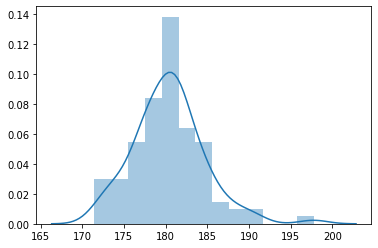

In [76]:
sns.distplot(sample)

In [86]:
usample = []
for i in range(1000):
    N = np.random.choice(range(cnts_ran.shape[0]), n_unstable)
    usample.append(cnts_ran.iloc[N]['s_interaction'].mean())

In [84]:
cnts[cnts.unstable==1].s_interaction.mean()

13.280561616527372

In [92]:
cnts[cnts.unstable==1].groupby('usupplier').size().mean()

28.65388711395101

In [93]:
cnts[cnts.unstable==0].groupby('usupplier').size().mean()

11.05554510747936

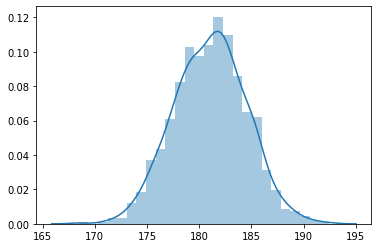

In [87]:
sns.distplot(usample)

In [88]:
usample = []
for i in range(100):
    N = np.random.choice(range(cnts_ran.shape[0]), n_unstable)
    usample.append(cnts_ran.iloc[N]['interaction'].mean())

In [89]:
cnts[cnts.unstable==1].interaction.mean()

11.631388779506333

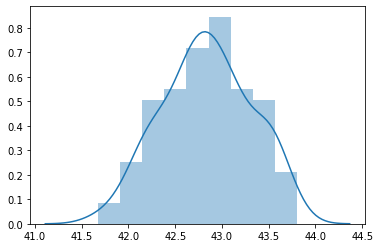

In [90]:
sns.distplot(usample)

In [131]:
sample = []
for i in range(100):
    N = np.random.choice(range(cnts_ran.shape[0]), n_sanctioned)
    sample.append(cnts_ran.iloc[N]['interaction'].mean())

In [132]:
cnts[cnts.sanctioned==1].interaction.mean()

4.764110948276914

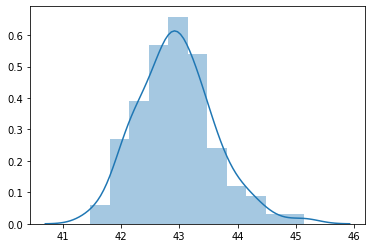

In [133]:
sns.distplot(sample)

In [156]:
usample = []
for i in range(1000):
    N = np.random.choice(range(cnts_ran.shape[0]), n_unstable)
    usample.append(cnts_ran.iloc[N]['atom'].mean())

In [151]:
cnts[cnts.unstable==1].atom.mean()

0.3205976362149706

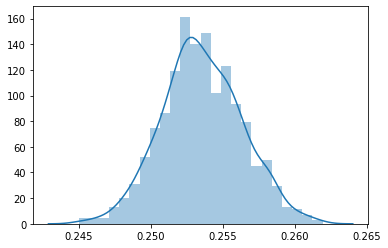

In [157]:
sns.distplot(usample)

In [158]:
sample = []
for i in range(1000):
    N = np.random.choice(range(cnts_ran.shape[0]), n_sanctioned)
    sample.append(cnts_ran.iloc[N]['atom'].mean())

In [154]:
cnts[cnts.sanctioned==1].atom.mean()

0.6213998568203095

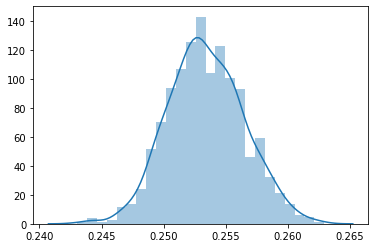

In [159]:
sns.distplot(sample)

# Evolution of contracts of unstable suppliers

In [96]:
s_volatile = s18 - s19

In [98]:
years = sorted(cnts.year.unique())

In [127]:
cnts[(cnts.year==2018) & (cnts.unstable==1)].groupby('usupplier').amount.mean().mean()

146198.6358410849

In [128]:
data = []
for y in years:
    N = cnts[(cnts.year==y) & (cnts.unstable==1)].groupby('usupplier').amount.mean().mean()
    data.append([str(y), N, "Unstable"])
    M = cnts[(cnts.year==y) & (cnts.sanctioned==1)].groupby('usupplier').amount.mean().mean()
    data.append([str(y), M, "Sanctioned"])
    O = cnts_ran[(cnts_ran.year==y)].groupby('usupplier').amount.mean().mean()
    data.append([str(y), O, "All"])

In [129]:
df = pd.DataFrame(data, columns=["Year", "Ncontracts", "Supplier"])

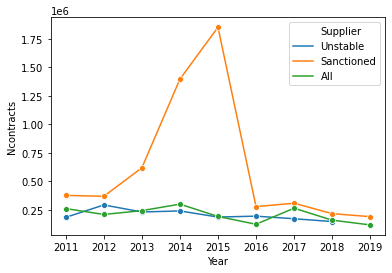

In [130]:
sns.lineplot(x="Year", y="Ncontracts", hue="Supplier", data=df, marker="o")

In [143]:
cnts.columns

Index(['id', 'start_date', 'amount', 'ramo', 'desc_ramo', 'person', 'buyer',
       'file_size', 'single_bid', 'contract_duration', 'prop_window',
       'daily_price', 'contract_type', 'gvmnt_level', 'buyer_state',
       'supplier_country', 'supplier', 'supplier_state', 'state_b', 'code_b',
       'state_s', 'code_s', 'ubuyer', 'usupplier', 'comp', 'long',
       'proportion_window', 'atom', 'buyer_dispersion', 'supplier_dispersion',
       'clustering', 'single_interaction', 'interaction', 's_interaction',
       'year', 'normed', 'sanctioned', 'unstable'],
      dtype='object')

In [147]:
cnts[cnts.unstable==1]['atom'].mean()

0.3205976362149706

In [148]:
cnts['atom'].mean()

0.25885622829706056

In [149]:
cnts[cnts.sanctioned==1].atom.mean()

0.6213998568203095